#%%[markdown]

 # Neural ODE mixed with SINDy framework with mixture of experts
## Summary
 - We have a multistable dynamical systems that we want to learn
 - We only learn on a single attrator
 - Does it learn the other attractor ?
## Aproach
 - We have a baisis of neural networks
 - We have a set of coefficients: one set = one dataset
 - Hopefully we get a foundational model

In [ ]:
#%%

import jax

print("Available devices:", jax.devices())

from jax import config
# config.update("jax_debug_nans", True)

import jax.numpy as jnp

import numpy as np
from scipy.integrate import solve_ivp

import equinox as eqx
import diffrax

# import matplotlib.pyplot as plt

from sinode import *

import optax
import time

Available devices: [cuda(id=0)]


In [ ]:
#%%

SEED = 2026
np.random.seed(SEED)
main_key = jax.random.PRNGKey(SEED)

dict_size = 8
mlp_hidden_size = 32
mlp_depth = 4
threshold_val = 1e-2
threshold_every = 100    ## Threshold the coeffs every this many epochs

# renormalize_every = 100
use_bias = False

power_iter_steps = 5
spectral_scaling = 1.0 # since the spectral norm is under-estimated wia power iter

fixed_point_steps = 5

## Optimiser hps
init_lr = 1e-4
sched_factor = 1.0

epsilon = 0e1  ## For contrastive loss
eta_inv, eta_cont, eta_spar = 1e-3, 1e-2, 1e-1

## Training hps
print_every = 100
nb_epochs = 5000
inner_steps_node = 10
inner_steps_coeffs = 10

## Proximal trianing hps
nb_outer_steps_max=nb_epochs
inner_tol_node=1e-9 
inner_tol_coeffs=1e-8
nb_inner_steps_max=max(inner_steps_coeffs, inner_steps_node)
proximal_reg=100.
patience=nb_epochs


## Data generation hps
T_horizon = 20
skip = 50

Data shape: (1, 12, 40, 2)
Data shape: (1, 12, 40, 2)


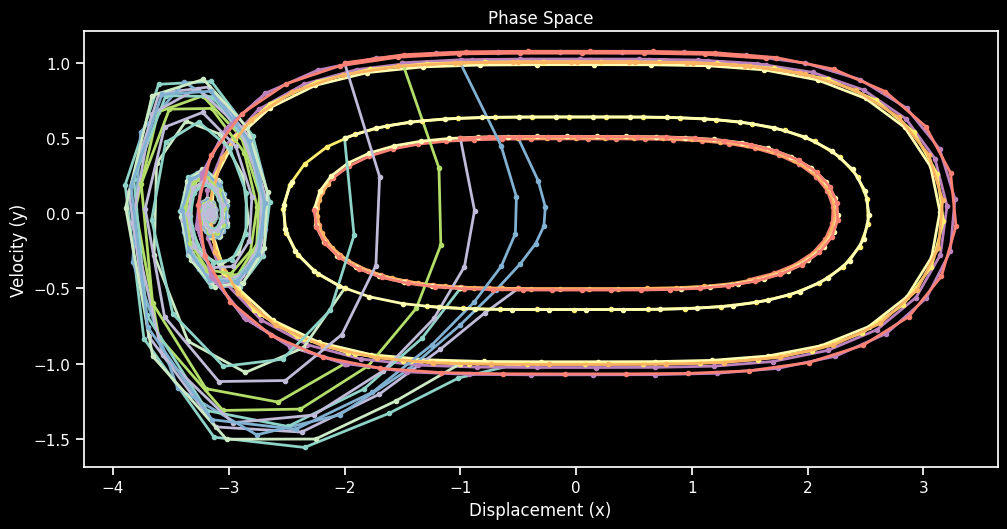

In [ ]:
#%%

# Define the Duffing system
def duffing(t, state, a, b, c):
    x, y = state
    dxdt = y
    dydt = a*y - x*(b + c*x**2)
    return [dxdt, dydt]

def cubic(t, state, a, b, c):
    x, y = state
    dxdt = y
    dydt = -c*x**3 / 5.
    return [dxdt, dydt]

# Parameters
a, b, c = -1/2., -1, 1/10.

t_span = (0, T_horizon)
t_eval = np.arange(t_span[0], t_span[1], 0.01)[::skip]

init_conds = np.array([[-0.5, -1], [-0.5, -0.5], [-0.5, 0.5], 
                       [-1.5, 1], 
                    #    [-0.5, 1], 
                       [-1, -1], [-1, -0.5], [-1, 0.5], [-1, 1], 
                       [-2, -1], [-2, -0.5], [-2, 0.5], [-2, 1],
                    #    [0.5, -1], [0.5, -0.5], [0.5, 0.5], [0.5, 1],
                    #    [1, -1], [1, -0.5], [1, 0.5], [1, 1],
                    #    [2, -1], [2, -0.5], [2, 0.5], [2, 1],
                       ])


# add_init_conds_x = np.random.uniform(-4, -0.5, 50)
# add_init_conds_y = np.random.uniform(-1.5, 0.75, 50)
# add_init_conds = np.stack([add_init_conds_x, add_init_conds_y], axis=-1)
# init_conds = np.concatenate([init_conds, add_init_conds], axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
train_data1 = []
train_data2 = []

for state0 in init_conds:
    sol1 = solve_ivp(duffing, t_span, state0, args=(a, b, c), t_eval=t_eval)
    train_data1.append(sol1.y.T)

    sol2 = solve_ivp(cubic, t_span, state0, args=(a, b, c), t_eval=t_eval)
    train_data2.append(sol2.y.T)

    ## Plot the phase space
    ax = sbplot(sol1.y[0], sol1.y[1], ".-", ax=ax, dark_background=True)
    ax = sbplot(sol2.y[0], sol2.y[1], ".-", ax=ax, dark_background=True)

ax.set_xlabel('Displacement (x)')
ax.set_ylabel('Velocity (y)')
ax.set_title('Phase Space')


## Save the training data
data1 = np.stack(train_data1)[None, ...]
data2 = np.stack(train_data2)[None, ...]

print("Data shape:", data1.shape)
print("Data shape:", data2.shape)

In [ ]:
# %%

class BasisFunction(eqx.Module):
    """ An MLP with a skip connection from input to output, and its inverse via fixed point iteration """
    layers: jnp.ndarray

    # transform: jnp.ndarray  ## Of size 3: scale, shift, power

    def __init__(self, in_size, out_size, hidden_size, depth, activation, key=None):
        keys = jax.random.split(key, num=depth+1)

        self.layers = []

        for i in range(depth):
            if i==0:
                layer = eqx.nn.Linear(in_size, hidden_size, use_bias=use_bias, key=keys[i])
            elif i==depth-1:
                layer = eqx.nn.Linear(hidden_size, out_size, use_bias=use_bias, key=keys[i])
            else:
                layer = eqx.nn.Linear(hidden_size, hidden_size, use_bias=use_bias, key=keys[i])

            self.layers.append(layer)

            if i != depth-1:
                self.layers.append(activation)

        # self.transform = jnp.array([1.0, 0.0, 1.0, 0.0])   ## Identity transform


    def __call__(self, x):
        """ Returns y such that y = x + MLP(x) """
        y = x
        for layer in self.layers:
            y = layer(y)
        return x + y

    def inv_call(self, x):
        """ Returns z such that x = z + MLP(z) via fixed point iteration """
        # pass
        # return x

        z = x
        for _ in range(fixed_point_steps):
            z = x - self(z)
        return z

        # a, b, a_, b_ = self.transform
        # # return (a*self(x) + b)**p
        # return a*self(a_*x + b_) + b


## Vectorise across the model
@eqx.filter_vmap(in_axes=(eqx.if_array(0), None))
def evaluate_funcs_dir(model, x):
    return model(x)

@eqx.filter_vmap(in_axes=(eqx.if_array(0), None))
def evaluate_funcs_inv(model, x):
    return model.inv_call(x)


class VectorField(eqx.Module):
    basis_funcs: BasisFunction

    def __init__(self, data_size, dict_size, mlp_hidden_size, mlp_depth, key=None):
        keys = jax.random.split(key, num=dict_size)

        def make_basis_func(key):
            return BasisFunction(data_size, data_size, mlp_hidden_size, mlp_depth, jax.nn.softplus, key=key)

        self.basis_funcs = eqx.filter_vmap(make_basis_func)(keys)


    def __call__(self, t, x, coeffs):
        """ Forward call of the vector field """
        lambdas, gammas = coeffs
        # assert lambdas.shape == gammas.shape == (self.dict_size, self.data_size)

        y_direct = evaluate_funcs_dir(self.basis_funcs, x)
        y_inverse = evaluate_funcs_inv(self.basis_funcs, x)

        return jnp.sum(y_direct*lambdas + y_inverse*gammas, axis=0)
        # return jnp.array([y_direct[0,0], y_direct[1,1]])
        # return jnp.sum(y_direct*lambdas, axis=0)


class Coefficients(eqx.Module):
    lambdas: jnp.ndarray
    gammas: jnp.ndarray

    def __init__(self, data_size, dict_size, key=None):
        # self.lambdas = jax.random.uniform(key, shape=(dict_size, data_size))
        # self.gammas = jax.random.uniform(key, shape=(dict_size, data_size))

        self.lambdas = jnp.zeros((dict_size, data_size))

        # self.lambdas = self.lambdas.at[0, 0].set(1.)            ## TODO: Remove this
        # self.lambdas = self.lambdas.at[1, 1].set(1.)
        # self.lambdas = self.lambdas.at[2].set(1.)

        self.gammas = jnp.zeros((dict_size, data_size))

    def __call__(self):
        return self.lambdas, self.gammas

class NeuralODE(eqx.Module):
    data_size: int
    dict_size: int
    mlp_hidden_size: int
    mlp_depth: int

    vector_field: VectorField

    def __init__(self, data_size, dict_size, mlp_hidden_size, mlp_depth, key=None):
        self.data_size = data_size
        self.dict_size = dict_size
        self.mlp_hidden_size = mlp_hidden_size
        self.mlp_depth = mlp_depth

        self.vector_field = VectorField(data_size, dict_size, mlp_hidden_size, mlp_depth, key=key)

    def __call__(self, x0s, t_eval, coeffs):

        def integrate(y0):
            sol = diffrax.diffeqsolve(
                    diffrax.ODETerm(self.vector_field),
                    diffrax.Tsit5(),
                    args=(coeffs.lambdas, coeffs.gammas),
                    t0=t_eval[0],
                    t1=t_eval[-1],
                    dt0=1e-3,
                    y0=y0,
                    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
                    saveat=diffrax.SaveAt(ts=t_eval),
                    # adjoint=diffrax.RecursiveCheckpointAdjoint(),
                    max_steps=4096
                )
            return sol.ys

            # sol = RK4(self.vector_field, 
            #           (t_eval[0], t_eval[-1]), 
            #           y0, 
            #           (coeffs.lambdas, coeffs.gammas), 
            #           t_eval=t_eval, 
            #           subdivisions=4)
            # return sol

        return eqx.filter_vmap(integrate)(x0s)

In [ ]:
# %%

model_keys = jax.random.split(main_key, num=3)

model = NeuralODE(data_size=2, dict_size=dict_size, mlp_hidden_size=mlp_hidden_size, mlp_depth=mlp_depth, key=model_keys[0])

coeffs1 = Coefficients(data_size=2, dict_size=dict_size, key=model_keys[1])
coeffs2 = Coefficients(data_size=2, dict_size=dict_size, key=model_keys[2])

In [ ]:
# %%

def loss_rec(model, coeffs, batch, key):
    """ Reconstruction loss """
    X, t = batch
    X_hat = model(X[:, 0, :], t, coeffs)
    return jnp.mean((X-X_hat)**2)

def loss_inv(model, coeffs, batch, key):
    """ Inverse loss - Assures the inverses are playing their roles """
    X, _ = batch

    @eqx.filter_vmap(in_axes=(None, 0))
    @eqx.filter_vmap(in_axes=(eqx.if_array(0), None))
    def eval_direct_inverse(basis_func, x):
        return basis_func(basis_func.inv_call(x))
    
    X_ = eval_direct_inverse(model.vector_field.basis_funcs, X.reshape(-1, model.data_size))
    X = X.reshape(-1, model.data_size)[:, None, :]

    return jnp.mean((X-X_)**2)

def loss_cont(model, coeffs, batch, key):
    """ Contrastive loss - Makes the weights of the models different """
    X, t = batch

    ## Extract and stack the weights along the last dimension
    basis_funcs = model.vector_field.basis_funcs
    weights = [layer.weight for layer in basis_funcs.layers if isinstance(layer, eqx.nn.Linear)]

    # print([w.shape for w in weights])

    # weights = jnp.stack(weights, axis=-1)

    ## Sample two weights along the first dimention
    ind = jax.random.permutation(key, model.dict_size)[:2]
    # w1, w2 = weights[ind, ...]

    tot_distance = 0.
    for d in range(len(weights)):
        w1, w2 = weights[d][ind[0], ...], weights[d][ind[1], ...]
        tot_distance += jnp.mean((w1-w2)**2)

    return epsilon - tot_distance        ## Maximise the difference between the weights up to epsilon

def loss_sparsity(model, coeffs, batch, key):
    """ Sparsity loss - Makes the coefficients sparse """
    return jnp.mean(jnp.abs(coeffs.lambdas) + jnp.abs(coeffs.gammas))



def loss_fn(model, coeffs, batch, key):

    rec_loss = loss_rec(model, coeffs, batch, key)
    inv_loss = loss_inv(model, coeffs, batch, key)
    cont_loss = loss_cont(model, coeffs, batch, key)
    spar_loss = loss_sparsity(model, coeffs, batch, key)

    return rec_loss + eta_inv*inv_loss + eta_cont*cont_loss + eta_spar*spar_loss
    # return rec_loss + eta_cont*cont_loss + eta_spar*spar_loss




@eqx.filter_jit
def train_step_node(model, coeffs, batch, opt_state, key):
    print('\nCompiling function "train_step" for Node ...\n')

    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, coeffs, batch, key)

    updates, opt_state = opt_node.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    return model, coeffs, opt_state, loss


@eqx.filter_jit
def train_step_coeffs(model, coeffs, batch, opt_state, key):
    print('\nCompiling function "train_step" for Coeffs...\n')

    new_loss_fn = lambda coeffs, model, batch, key: loss_fn(model, coeffs, batch, key)
    loss, grads = eqx.filter_value_and_grad(new_loss_fn)(coeffs, model, batch, key)

    updates, opt_state = opt_coeffs.update(grads, opt_state)
    coeffs = eqx.apply_updates(coeffs, updates)

    return model, coeffs, opt_state, loss


@eqx.filter_jit
def threshold_coeffs(coeffs, threshold_val):
    ## Jnp where every values above threshold is set to 1, else 0
    clip = lambda x: jnp.where(jnp.abs(x)>=threshold_val, x, 0.)
    return jax.tree.map(clip, coeffs)


def power_iteration(matrix, nb_iters, key):
    """ Power iteration for a single matrix """
    u = jax.random.normal(key, (matrix.shape[0],))
    v = jax.random.normal(key, (matrix.shape[1],))

    for _ in range(nb_iters):
        v = matrix.T@u
        v = v / jnp.linalg.norm(v)
        u = matrix@v
        u = u / jnp.linalg.norm(u)

    return u.T@matrix@v

@eqx.filter_jit
@eqx.filter_vmap(in_axes=(eqx.if_array(0), None, None))
def renormalize_model(model, nb_iters, key):
    """ Renormalize the model to have a spectral norm of 1 """

    # def appply_func(x):
    #     if jnp.ndim(x)==2:
    #         return x / power_iteration(x, nb_iters, key)
    #     else:
    #         return x


    def appply_func(x):
        if jnp.ndim(x)==2:
            spectral_norm = power_iteration(x, nb_iters, key)
            return jax.lax.cond((spectral_scaling / spectral_norm) < 1.,
                                lambda z: spectral_scaling * z / spectral_norm, 
                                lambda z: z,
                                operand=x)
        else:
            return x


    return jax.tree.map(appply_func, model)

In [ ]:
#%%

total_steps = nb_epochs     ## 1 step per epoch with full batch

boundaries_and_scales={int(total_steps*0.25):sched_factor, int(total_steps*0.5):sched_factor, int(total_steps*0.75):sched_factor}

# sched = optax.linear_schedule(init_lr, 0, total_steps, 0.25)
sched_node = optax.piecewise_constant_schedule(init_value=init_lr, boundaries_and_scales=boundaries_and_scales)
sched_coeffs = optax.piecewise_constant_schedule(init_value=init_lr, boundaries_and_scales=boundaries_and_scales)

nb_data_points = data1.shape[1]
batch_size = nb_data_points


opt_node = optax.adam(sched_node)
opt_state_node = opt_node.init(eqx.filter(model, eqx.is_array))

opt_coeffs1 = optax.adam(sched_coeffs)
opt_state_coeffs1 = opt_coeffs1.init(eqx.filter(coeffs1, eqx.is_array))

opt_coeffs2 = optax.adam(sched_coeffs)
opt_state_coeffs2 = opt_coeffs2.init(eqx.filter(coeffs2, eqx.is_array))

coeffs = (coeffs1, coeffs2)
opt_state_coeffs = (opt_state_coeffs1, opt_state_coeffs2)


# start_time = time.time()

# print(f"\n\n=== Beginning Training ... ===")

# train_key, _ = jax.random.split(main_key)

# losses_node = []
# losses_coeffs = []

# for epoch in range(nb_epochs):

#     nb_batches = 0
#     loss_sum_node = 0.
#     loss_sum_coeffs = 0.

#     for i in range(0, nb_data_points, batch_size):
#         batch = (data[0,i:i+batch_size,...], t_eval)
    
#         for _ in range(inner_steps_node):
#             train_key, _ = jax.random.split(train_key)
#             model, coeffs, opt_state_node, loss = train_step_node(model, coeffs, batch, opt_state_node, train_key)

#         loss_sum_node += loss

#         for _ in range(inner_steps_coeffs):
#             train_key, _ = jax.random.split(train_key)
#             model, coeffs, opt_state_coeffs, loss = train_step_coeffs(model, coeffs, batch, opt_state_coeffs, train_key)
#         loss_sum_coeffs += loss

#         nb_batches += 1


#     # if epoch%renormalize_every==0:      ## TODO Check this
#     #     ## Renormalise the matrices to ensure they are invertible
#     #     train_key, _ = jax.random.split(train_key)
#     #     model = renormalize_model(model, power_iter_steps, train_key)

#     if epoch%threshold_every==0:
#         ## Threshold the coefficients
#         coeffs = threshold_coeffs(coeffs, threshold_val)


#     loss_epoch_node = loss_sum_node/nb_batches
#     losses_node.append(loss_epoch_node)

#     loss_epoch_coeffs = loss_sum_coeffs/nb_batches
#     losses_coeffs.append(loss_epoch_coeffs)

#     if epoch%print_every==0 or epoch<=3 or epoch==nb_epochs-1:
#         print(f"    Epoch: {epoch:-5d}      LossNode: {loss_epoch_node:.8f}      LossCoeffs: {loss_epoch_coeffs:.8f}", flush=True)

# wall_time = time.time() - start_time
# time_in_hmsecs = seconds_to_hours(wall_time)
# print("\nTotal GD training time: %d hours %d mins %d secs" %time_in_hmsecs)

In [ ]:
#%%

""" Train the model using the proximal gradient descent algorithm. Algorithm 2 in https://proceedings.mlr.press/v97/li19n.html"""


def loss_fn_aux(model, coeffs, batch, key):

    rec_loss = loss_rec(model, coeffs, batch, key)
    inv_loss = loss_inv(model, coeffs, batch, key)
    cont_loss = loss_cont(model, coeffs, batch, key)
    spar_loss = loss_sparsity(model, coeffs, batch, key)

    loss_val = rec_loss + eta_inv*inv_loss + eta_cont*cont_loss + eta_spar*spar_loss

    return loss_val, (rec_loss, inv_loss, cont_loss, spar_loss)


@eqx.filter_jit
def train_step_node(node, node_old, coeffs, batch, opt_state, key):
    print('\nCompiling function "train_step" for neural ode ...')

    batch1, batch2 = batch
    coeffs1, coeffs2 = coeffs

    def prox_loss_fn(node, coeffs, batch, key):
        loss, aux_data = loss_fn_aux(node, coeffs, batch, key)
        diff_norm = params_diff_norm_squared(node, node_old)
        return loss + proximal_reg * diff_norm / 2., (*aux_data, diff_norm)

    grad_loss_fn = eqx.filter_value_and_grad(prox_loss_fn, has_aux=True)

    (loss1, aux_data1), grads1 = grad_loss_fn(node, coeffs1, batch1, key)
    (loss2, aux_data2), grads2 = grad_loss_fn(node, coeffs2, batch2, key)

    updates, opt_state = opt_node.update(grads1, opt_state)
    node = eqx.apply_updates(node, updates)

    updates, opt_state = opt_node.update(grads2, opt_state)
    node = eqx.apply_updates(node, updates)

    loss = (loss1 + loss2) / 2.

    aux_data = []
    for i in range(len(aux_data1)):
        aux_data.append((aux_data1[i] + aux_data2[i]) / 2.)

    return node, coeffs, opt_state, loss, tuple(aux_data)


@eqx.filter_jit
def train_step_coeffs(node, coeffs, coeffs_old, batch, opt_state, key):
    print('\nCompiling function "train_step" for coeffs ...')

    coeffs1, coeffs2 = coeffs
    batch1, batch2 = batch
    opt_state1, opt_state2 = opt_state
    coeffs_old1, coeffs_old2 = coeffs_old

    def prox_loss_fn(coeffs, node, batch, coeffs_old, key):
        loss, aux_data = loss_fn_aux(node, coeffs, batch, key)
        diff_norm = params_diff_norm_squared(coeffs, coeffs_old)
        return loss + proximal_reg * diff_norm / 2., (*aux_data, diff_norm)

    grad_loss_fn = eqx.filter_value_and_grad(prox_loss_fn, has_aux=True)

    (loss1, aux_data1), grads1 = grad_loss_fn(coeffs1, node, batch1, coeffs_old1, key)
    (loss2, aux_data2), grads2 = grad_loss_fn(coeffs2, node, batch2, coeffs_old2, key)

    updates1, opt_state1 = opt_coeffs1.update(grads1, opt_state1)
    updates2, opt_state2 = opt_coeffs2.update(grads2, opt_state2)

    coeffs1 = eqx.apply_updates(coeffs1, updates1)
    coeffs2 = eqx.apply_updates(coeffs2, updates2)

    coeffs = (coeffs1, coeffs2)
    opt_state = (opt_state1, opt_state2)
    loss = (loss1 + loss2) / 2.

    aux_data = []
    for i in range(len(aux_data1)):
        aux_data.append((aux_data1[i] + aux_data2[i]) / 2.)

    return node, coeffs, opt_state, loss, tuple(aux_data)


print(f"\n\n=== Beginning training with proximal alternating minimization ... ===")
print(f"    Number of examples in a batch: {batch_size}")
print(f"    Maximum number of steps per inner minimization: {nb_inner_steps_max}")
print(f"    Maximum number of outer minimizations: {nb_outer_steps_max}")
print(f"    Maximum total number of training steps: {nb_outer_steps_max*nb_inner_steps_max}")

start_time = time.time()

losses_node = []
losses_coeffs = []
# nb_steps_node = []
# nb_steps_coeffs = []

val_losses = []

train_key, _ = jax.random.split(main_key)

early_stopping_count = 0

for out_step in range(nb_outer_steps_max):

    node_old = model
    coeffs_old = (coeffs[0], coeffs[1])

    node_prev = model
    for in_step_node in range(nb_inner_steps_max):

        nb_batches_node = 0
        loss_sum_node = jnp.zeros(1)
        nb_steps_eph_node = 0

        for i in range(0, nb_data_points, batch_size):
            batch1 = (data1[0,i:i+batch_size,...], t_eval)
            batch2 = (data2[0,i:i+batch_size,...], t_eval)
            batch = (batch1, batch2)

            train_key, _ = jax.random.split(train_key)

            model, coeffs, opt_state_node, loss_node, aux_data = train_step_node(model, node_old, coeffs, batch, opt_state_node, train_key)

            loss_sum_node += jnp.array([loss_node])
            # nb_steps_eph_node += nb_steps_node_

            nb_batches_node += 1

        diff_node = params_diff_norm_squared(model, node_prev) / params_norm_squared(node_prev)
        if diff_node < inner_tol_node or out_step==0:
            break
        node_prev = model

    loss_epoch_node = loss_sum_node/nb_batches_node


    coeffs_prev = (coeffs[0], coeffs[1])
    for in_step_coeffs in range(nb_inner_steps_max):

        nb_batches_ctx = 0
        loss_sum_coeffs = jnp.zeros(1)
        nb_steps_eph_coeffs = 0

        for i in range(0, nb_data_points, batch_size):
            batch1 = (data1[0,i:i+batch_size,...], t_eval)
            batch2 = (data2[0,i:i+batch_size,...], t_eval)
            batch = (batch1, batch2)

            train_key, _ = jax.random.split(train_key)

            model, coeffs, opt_state_coeffs, loss_coeffs, aux_data = train_step_coeffs(model, coeffs, coeffs_old, batch, opt_state_coeffs, train_key)

            loss_sum_coeffs += jnp.array([loss_coeffs])
            # nb_steps_eph_coeffs += nb_steps_coeffs_

            nb_batches_ctx += 1

        coeffs1, coeffs2 = coeffs
        opt_state_coeffs1, opt_state_coeffs2 = opt_state_coeffs

        diff_coeffs = params_diff_norm_squared(coeffs, coeffs_prev) / params_norm_squared(coeffs_prev)
        if diff_coeffs < inner_tol_coeffs or out_step==0:
            break
        coeffs_prev = (coeffs1, coeffs2)

    loss_epoch_coeffs = loss_sum_coeffs/nb_batches_ctx

    if out_step%threshold_every==0:
        ## Threshold the coefficients
        coeffs = threshold_coeffs(coeffs, threshold_val)


    losses_node.append(loss_epoch_node)
    losses_coeffs.append(loss_epoch_coeffs)
    # nb_steps_node.append(nb_steps_eph_node)
    # nb_steps_ctx.append(nb_steps_eph_ctx)

    if out_step%print_every==0 or out_step<=3 or out_step==nb_outer_steps_max-1:

        print(f"    Epoch: {out_step:-5d}      LossTrajs: {loss_epoch_node[0]:-.8f}     LossTerms: {[d.tolist() for d in aux_data]}", flush=True)

        print(f"        -NbInnerStepsNode: {in_step_node+1:4d}\n        -NbInnerStepsCoeffs: {in_step_coeffs+1:4d}\n        -InnerToleranceNode: {inner_tol_node:.2e}\n        -InnerToleranceCoeffs:  {inner_tol_coeffs:.2e}\n        -DiffNode: {diff_node:.2e}\n        -DiffCoeffs:  {diff_coeffs:.2e}", flush=True)

    if in_step_node < 1 and in_step_coeffs < 1:
        early_stopping_count += 1
    else:
        early_stopping_count = 0

    if (patience is not None) and (early_stopping_count >= patience):
        print(f"Stopping early after {patience} steps with no improvement in the loss. Consider increasing the tolerances for the inner minimizations.")
        break


wall_time = time.time() - start_time
time_in_hmsecs = seconds_to_hours(wall_time)
print("\nTotal gradient descent training time: %d hours %d mins %d secs" %time_in_hmsecs)



=== Beginning training with proximal alternating minimization ... ===
    Number of examples in a batch: 12
    Maximum number of steps per inner minimization: 10
    Maximum number of outer minimizations: 5000
    Maximum total number of training steps: 50000

Compiling function "train_step" for neural ode ...

Compiling function "train_step" for coeffs ...
    Epoch:     0      LossTrajs: 2.66475248     LossTerms: [2.6664772033691406, 3.3277103900909424, -0.38849663734436035, 0.0, 0.0]
        -NbInnerStepsNode:    1
        -NbInnerStepsCoeffs:    1
        -InnerToleranceNode: 1.00e-09
        -InnerToleranceCoeffs:  1.00e-08
        -DiffNode: 2.20e-06
        -DiffCoeffs:  inf
    Epoch:     1      LossTrajs: 2.66621637     LossTerms: [2.460947036743164, 3.1840014457702637, -0.4267764091491699, 0.0017399173229932785, 7.637734142917907e-07]
        -NbInnerStepsNode:   10
        -NbInnerStepsCoeffs:   10
        -InnerToleranceNode: 1.00e-09
        -InnerToleranceCoeffs:  1.00

KeyboardInterrupt: 

In [ ]:
# %%

## Shift the losses so that they start from 0
losses_node, losses_coeffs = np.array(losses_node), np.array(losses_coeffs)
min_loss = min(np.min(losses_node), np.min(losses_coeffs), 0.)
losses_node += abs(min_loss)
losses_coeffs += abs(min_loss)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sbplot(losses_node, x_label='Epoch', y_label='L2', y_scale="log", label='Losses Node', ax=ax, dark_background=True);
ax = sbplot(losses_coeffs[::], ".", y_scale="log", label='Losses Coeffs', ax=ax, dark_background=True);

plt.savefig(f"data/loss.png", dpi=300, bbox_inches='tight')
plt.legend()
# plt.show()

# losses_coeffs

: 

In [ ]:
#%% 

eqx.tree_serialise_leaves("data/sinode_model_10.eqx", model)
eqx.tree_serialise_leaves("data/sinode_coeffs_10.eqx", coeffs)

: 

In [ ]:
# %%

# model = eqx.tree_deserialise_leaves("data/sinode_model_08.eqx", model)
# coeffs = eqx.tree_deserialise_leaves("data/sinode_coeffs_08.eqx", coeffs)

coeffs1, coeffs2 = coeffs

coeffs_ = coeffs1
ode_system = duffing

# coeffs_ = coeffs2
# ode_system = cubic

## %%

## Test the model
def test_model(model, coeffs, batch, key):
    X0, t = batch
    X_hat = model(X0[:, :], t, coeffs)
    return X_hat

init_conds_test = np.array([[-0.5, -1], [-0.5, -0.5], [-0.5, 0.5], 
                       [-1.5, 1], 
                    #    [-0.5, 1], 
                       [-1, -1], [-1, -0.5], [-1, 0.5], [-1, 1], 
                       [-2, -1], [-2, -0.5], [-2, 0.5], [-2, 1],
                       [0.5, -1], [0.5, -0.5], [0.5, 0.5], [0.5, 1],
                       [1, -1], [1, -0.5], [1, 0.5], [1, 1],
                       [2, -1], [2, -0.5], [2, 0.5], [2, 1],
                       ])
test_data = []
for state0 in init_conds_test:
    sol = solve_ivp(ode_system, t_span, state0, args=(a, b, c), t_eval=t_eval)
    test_data.append(sol.y.T)
test_data = np.stack(test_data)[None, ...]



X = test_data[0, :, :, :]
# t = np.linspace(t_span[0], t_span[1], T_horizon)
t = t_eval

test_key, _ = jax.random.split(main_key)

saved_gammas = coeffs_.gammas
saved_lambdas = coeffs_.lambdas

for i in range(1):
# for i in range(dict_size):
#     print("Setting zeros at position: ", i)

#     new_lambdas = saved_lambdas.at[i].set(0.)
#     new_gammas = saved_gammas.at[i].set(0.)

#     # new_lambdas = saved_lambdas.at[i].mul(2.)
#     # new_gammas = saved_gammas.at[i].mul(2.)

#     # new_lambdas = jnp.zeros_like(saved_lambdas)
#     # new_gammas = jnp.zeros_like(saved_gammas)
#     # new_lambdas = new_lambdas.at[i].set(saved_lambdas[i])
#     # new_gammas = new_gammas.at[i].set(saved_gammas[i])

#     coeffs_ = eqx.tree_at(lambda m: m.lambdas, coeffs_, new_lambdas)
#     coeffs_ = eqx.tree_at(lambda m: m.gammas, coeffs_, new_gammas)

    X_hat = test_model(model, coeffs_, (X[:, 0,:], t), test_key)

    print(f"Test MSE: {jnp.mean((X-X_hat)**2):.8f}")

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'yellow', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    colors = colors*10

    for i in range(X.shape[0]):
        if i==0:
            sbplot(X_hat[i, :,0], X_hat[i, :,1], "-", x_label='x', y_label='y', label=f'Pred', title=f'Phase space', ax=ax, alpha=0.5, color=colors[i])
            sbplot(X[i, :,0], X[i, :,1], "+", lw=1, label=f'True', ax=ax, color=colors[i])
        else:
            sbplot(X_hat[i, :,0], X_hat[i, :,1], "-", x_label='x', y_label='y', ax=ax, alpha=0.5, color=colors[i])
            sbplot(X[i, :,0], X[i, :,1], "+", lw=1, ax=ax, color=colors[i])

    ## Limit ax x and y axis to (-5,5)
    # ax.set_xlim(-5, 5)
    # ax.set_ylim(-5, 5)
    plt.show()



plt.savefig(f"data/test_traj.png", dpi=300, bbox_inches='tight')

: 

In [ ]:
#%% 

# ## Print coeffs_
print("coeffs_: \n\t  - Lambdas: \n", coeffs_.lambdas, "\n\n\t  - Gammas: \n", coeffs_.gammas)
# print("coeffs_: \n\t  - Lambdas: \n", coeffs_.lambdas)

## Print cloeffs lambda with abs > 1e-2
active_coeffs_ = jnp.where(jnp.abs(coeffs_.lambdas)>=threshold_val, 1, 0)
print("Active coefficients lambda: \n", active_coeffs_)

## Same for gammas
active_coeffs_ = jnp.where(jnp.abs(coeffs_.gammas)>=threshold_val, 1, 0)
print("Active coefficients gammas: \n", active_coeffs_)

## Count the number of paramters in the model
params = eqx.filter(model, eqx.is_array)
nb_params = jnp.sum(jnp.array([jnp.prod(jnp.array(p.shape)) for p in jax.tree.flatten(params)[0]]))
print(f"\nNumber of parameters in the model: {nb_params}")

## Print model basis functions
# print("Model basis functions: ", model.vector_field.basis_funcs.layers)
# print("Model basis functions: ", model.vector_field.basis_funcs.layers[2].weight)


## Evaluate the vector field a few points
print("Vector field at [1,1]: \n", evaluate_funcs_dir(model.vector_field.basis_funcs, jnp.array([1., 1.])))
print("Vector field at [2,2]: \n", evaluate_funcs_dir(model.vector_field.basis_funcs, jnp.array([2., 2.])))

: 

# %% [markdown]

 # Preliminary results
 - Nothing yet !